In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(r"C:\Mini_H\kickstarter\data\kickstarter.csv")

In [ ]:
print(df["state"].unique())

['successful' 'failed' 'live' 'canceled' 'submitted' 'started' 'suspended']


In [5]:
## karena hanya butuh binary saja sukses atau tidak jadi ambil hanya 2

df_model = df[df["state"].isin(["successful", "failed"])].copy()

In [14]:
## encode target
df_model["target"] = (df_model["state"] == "successful").astype(int)

print("Shape setelah filter:", df_model.shape)
print(df_model["target"].value_counts(normalize=True))

Shape setelah filter: (222350, 50)
target
1    0.656443
0    0.343557
Name: proportion, dtype: float64


In [6]:
## rubah timestampp ke datetime
df_model["launched_at"] = pd.to_datetime(df_model["launched_at"], unit="s")
df_model["deadline"] = pd.to_datetime(df_model["deadline"], unit="s")

In [7]:
## durasi kampanye
df_model["duration_days"] = (df_model["deadline"] - df_model["launched_at"]).dt.days

In [8]:
## target goal dalam USD
df_model["usd_goal_real"] = df_model["goal"] * df_model["static_usd_rate"]

In [9]:
## panjang tesk bulb
df_model["title_len"] = df_model["name"].astype(str).str.len()
df_model["blurb_len"] = df_model["blurb"].astype(str).str.len()

In [ ]:
print(df_model[["duration_days","usd_goal_real","title_len","blurb_len"]].describe())

       duration_days  usd_goal_real      title_len      blurb_len
count  222350.000000   2.223500e+05  222350.000000  222350.000000
mean       32.924605   3.128449e+04      35.506530     103.807826
std        12.706842   9.282272e+05      15.545039      31.653932
min         1.000000   1.000000e-02       1.000000       1.000000
25%        29.000000   1.217983e+03      22.000000      83.000000
50%        30.000000   4.150059e+03      35.000000     116.000000
75%        35.000000   1.080544e+04      49.000000     130.000000
max       120.000000   1.314698e+08      85.000000     151.000000


1. duration_days (lama kampanye)  
Rata-rata: 32.9 hari → sesuai pola Kickstarter (kampanye biasanya 30 hari).  
Min: 1 hari → mungkin kampanye eksperimen / data error.  
Max: 120 hari → ada kampanye yang panjang sekali (padahal jarang sukses).  
Insight: Mayoritas kampanye berlangsung 29–35 hari, menunjukkan standar optimal sekitar sebulan.  
  
2. usd_goal_real (target dana USD)  
Median: $4,150 (cukup realistis).  
Mean: $31,284 → jauh lebih tinggi dari median, artinya ada outlier target sangat besar.  
Max: $131 juta 😅 → jelas outlier, biasanya proyek ambisius yang gagal.  
Insight: Target dana realistis cenderung di bawah $10k, sementara target ratusan ribu/juta jarang tercapai.  
  
3. title_len (panjang judul)  
Median: 35 karakter → sekitar 5–6 kata, cukup ringkas.  
Max: 85 karakter → judul panjang sekali, bisa membingungkan.  
Insight: Judul proyek idealnya 20–50 karakter (padat, jelas, mudah diingat).  
  
4. blurb_len (panjang deskripsi singkat)  
Median: 116 karakter → cukup detail untuk pitch singkat.  
Max: 151 karakter (mungkin ada batas dari Kickstarter).  
Insight: Blurb biasanya 80–130 karakter, cukup untuk menjelaskan inti proyek.  
  
Kesimpulan sementara :  
Mayoritas kampanye sesuai “aturan emas” Kickstarter: durasi ~30 hari, target goal moderat, judul ringkas, blurb jelas.  
Outlier ada pada target dana sangat tinggi (hingga >100 juta USD) → perlu di-handle supaya model tidak bias.  
Fitur yang kita buat sudah masuk akal untuk prediksi sukses/gagal.

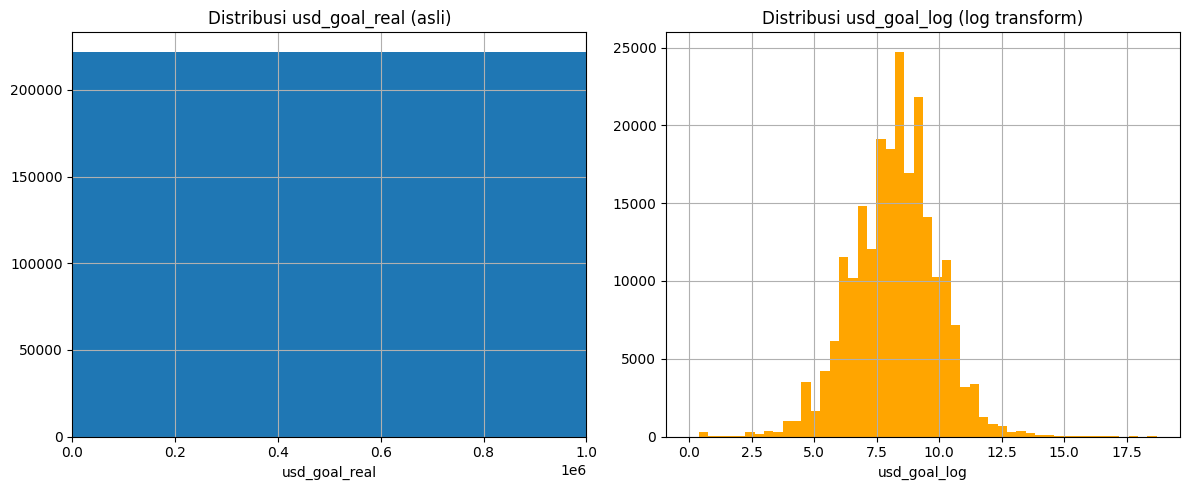

       usd_goal_real   usd_goal_log
count   2.223500e+05  222350.000000
mean    3.128449e+04       8.241635
std     9.282272e+05       1.714412
min     1.000000e-02       0.009950
25%     1.217983e+03       7.105772
50%     4.150059e+03       8.331119
75%     1.080544e+04       9.287898
max     1.314698e+08      18.694288


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# buat kolom log transform
df_model["usd_goal_log"] = np.log1p(df_model["usd_goal_real"])  # log(1 + x)

# cek distribusi sebelum & sesudah
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df_model["usd_goal_real"].hist(bins=50)
plt.title("Distribusi usd_goal_real (asli)")
plt.xlabel("usd_goal_real")
plt.xlim(0, 1e6)  # fokus < 1 juta biar ga 'meledak' ke kanan

plt.subplot(1,2,2)
df_model["usd_goal_log"].hist(bins=50, color="orange")
plt.title("Distribusi usd_goal_log (log transform)")
plt.xlabel("usd_goal_log")

plt.tight_layout()
plt.show()

print(df_model[["usd_goal_real","usd_goal_log"]].describe())


### setelah dilakukan Trasnformasi log untuk USD goal  
Distribusi setelah log transform lebih stabil, tidak lagi didominasi oleh outlier.  
Model (Logistic Regression, Random Forest, dll) akan lebih mudah belajar.  
Jadi, fitur untuk modeling sebaiknya pakai usd_goal_log, bukan usd_goal_real.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [12]:
import ast

def extract_category_name(x):
    try:
        # ubah string JSON → dict
        data = ast.literal_eval(x)  
        return data.get("parent_name", None), data.get("name", None)
    except Exception:
        return None, None

df_model[["category_parent", "category_sub"]] = df_model["category"].apply(
    lambda x: pd.Series(extract_category_name(x))
)

print(df_model[["category", "category_parent", "category_sub"]].head(3))


                                            category category_parent  \
0  {"id":340,"name":"Space Exploration","analytic...      Technology   
1  {"id":340,"name":"Space Exploration","analytic...      Technology   
2  {"id":340,"name":"Space Exploration","analytic...      Technology   

        category_sub  
0  Space Exploration  
1  Space Exploration  
2  Space Exploration  


In [25]:
# ----------------------------------------------------
# Step 4. Split Data & Preprocessing
# ----------------------------------------------------
# fitur numerik (pakai usd_goal_log)
features_num = ["usd_goal_log", "backers_count", "duration_days", "title_len", "blurb_len"]

# fitur kategorikal
features_cat = ["category_parent", "country"]

X = df_model[features_num + features_cat]
y = df_model["target"]

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat)
    ]
)

# fit & transform
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Shape X_train:", X_train_transformed.shape)
print("Shape X_test:", X_test_transformed.shape)

Train shape: (177880, 7)
Test shape: (44470, 7)
Shape X_train: (177880, 46)
Shape X_test: (44470, 46)


In [15]:
# backer count disini di drop karena dianggap data leakage
# fitur numerik (pakai usd_goal_log)
features_num = ["usd_goal_log", "duration_days", "title_len", "blurb_len"]

# fitur kategorikal
features_cat = ["category_parent", "country"]

X = df_model[features_num + features_cat]
y = df_model["target"]

# split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat)
    ]
)

# fit & transform
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Shape X_train:", X_train_transformed.shape)
print("Shape X_test:", X_test_transformed.shape)

Train shape: (177880, 6)
Test shape: (44470, 6)
Shape X_train: (177880, 45)
Shape X_test: (44470, 45)


## save ke .pkl

In [16]:
import joblib

joblib.dump(preprocessor, "../models/preprocessor.pkl")
joblib.dump((X_train, X_test, y_train, y_test), "../models/split_data.pkl")

['../models/split_data.pkl']